In [94]:
# Autor: Luiz Felipe Barro Alves
# data: 20/04/2025

# $$\text{INFORMAÇÕES SOBRE O CÓDIGO:}$$
- ## Cada célula deste código descreve e executa cada uma das etapas necessárias para a implementação da atividade.

In [95]:
# Bibliotecas utilizadas
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.io import wavfile
from scipy.signal import remez, freqz

# Sinal de áudio

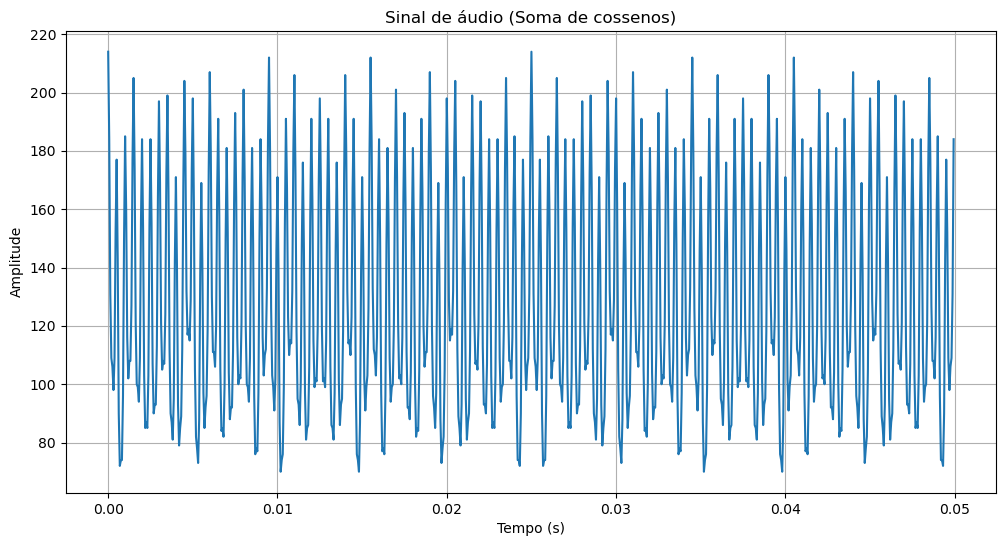

In [96]:
sample_rate, data = wavfile.read('sinal_1.wav')

time  = np.linspace(0.0, (1/sample_rate)*len(data), len(data))
visual_time = 0.05 # Tempo de visualização, pois há muitas amostras para plotar
n_samples = int(sample_rate * visual_time) # Quantidade de amostras a serem plotadas

plt.figure(figsize=(12, 6))
plt.plot(time[:n_samples], data[:n_samples])
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de áudio (Soma de cossenos)")
plt.grid()
plt.show()

# Determinando as componentes de frequência via FFT da biblioteca numpy

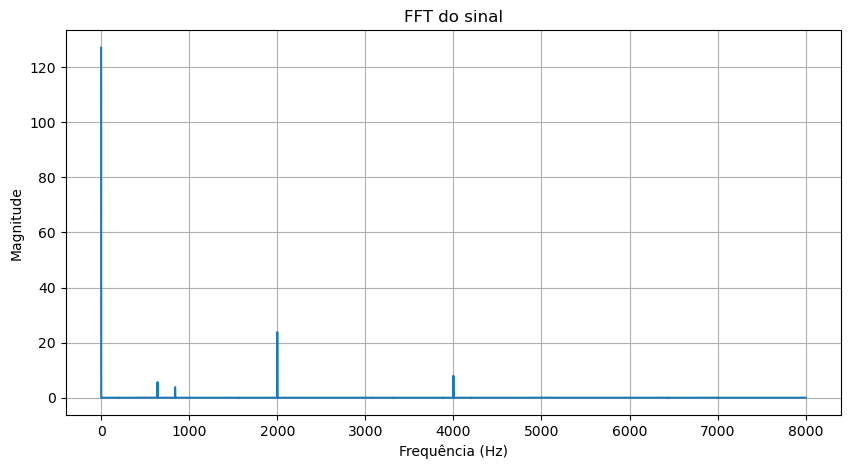

In [97]:
N = len(data)

# Calculando a FFT
fft_result = np.fft.fft(data)
fft_freqs = np.fft.fftfreq(N, d=1/sample_rate)

# Pegando apenas a parte positiva da FFT (por simetria)
half_N = N // 2
fft_freqs = fft_freqs[:half_N]
fft_magnitude = np.abs(fft_result[:half_N]) / N  
# Plot
plt.figure(figsize=(10, 5))
plt.plot(fft_freqs, fft_magnitude)
plt.title('FFT do sinal')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


In [98]:
# Índices das 6 maiores amplitudes
top5_idx = np.argsort(fft_magnitude)[-6:]

# Frequências correspondentes
top5_freqs = fft_freqs[top5_idx]
top5_mags = fft_magnitude[top5_idx]

# Exibindo os resultados
for f, m in zip(top5_freqs, top5_mags):
    print(f'Frequência: {f:.2f} Hz, Magnitude: {m:.3f}')


Frequência: 839.99 Hz, Magnitude: 3.853
Frequência: 640.03 Hz, Magnitude: 4.428
Frequência: 639.98 Hz, Magnitude: 5.644
Frequência: 4000.00 Hz, Magnitude: 7.951
Frequência: 2000.00 Hz, Magnitude: 23.821
Frequência: 0.00 Hz, Magnitude: 127.029


# Determinando as componentes de frequência via DFT implementada na disciplina

In [99]:
N = 2**10 # Tamanho da DFT

k = np.array([np.arange(0, N)]) # Número de amostras
n = np.arange(0, N) # Índice do somatório
k_T = k.reshape(-1, 1) # Número de amostras organizadas como uma matriz Nx1

In [100]:
func = data[:N]
func_T = func.reshape(-1, 1) # Amostras organizadas como uma matriz Nx1

Wn = np.exp(-2j*np.pi/N) # Definição de Wn

M_result = Wn**(k_T*n) # Matriz com as exponenciais complexas

DFT = M_result @ func_T

<>:9: SyntaxWarning: invalid escape sequence '\O'
<>:9: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_4847/3260303011.py:9: SyntaxWarning: invalid escape sequence '\O'
  axs.set_xlabel('$|\Omega[k]$')


[Text(0.0, 0, '0'),
 Text(0.7853981633974483, 0, '$\\pi/4$'),
 Text(1.5707963267948966, 0, '$\\pi/2$'),
 Text(2.356194490192345, 0, '$3\\pi/4$'),
 Text(3.141592653589793, 0, '$\\pi$')]

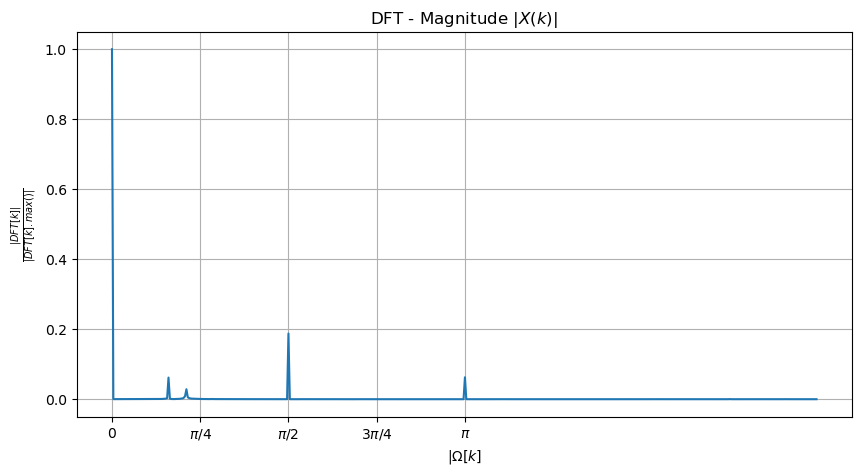

In [101]:
xticks = [0, np.pi/4, np.pi/2, (3*np.pi)/4, np.pi]
xticklabels = ['0', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$']
# Pegando apenas a parte positiva da FFT (por simetria)
half_N = N // 2

fig, axs  = plt.subplots(1, 1, figsize=(10,5))

axs.plot(2*np.pi*k_T[:half_N]/half_N, np.abs(DFT[:half_N])/np.abs(DFT.max()))
axs.set_xlabel('$|\Omega[k]$')
axs.set_ylabel(r'$\frac{|DFT[k]|}{|DFT[k].max()|}$')
axs.grid()
axs.set_title('DFT - Magnitude |$X(k)$|')
axs.set_xticks(xticks)
axs.set_xticklabels(xticklabels)
# axs.set_ylim([0,0.029])

## Frequência de cada componente

In [102]:
amplitude = abs(DFT.flatten())/abs(DFT.max())
DFT_freq = np.array([])
j = 0
for i in amplitude[:N//2]:
    if (i >= 0.027):
        DFT_freq = np.append(DFT_freq, (j/N)*sample_rate)
    j += 1
print('Frequência de cada componente:', DFT_freq,'Hz')

Frequência de cada componente: [   0.     640.625  843.75  2000.    4000.   ] Hz


# Aplicação de Filtros de Resposta Finita ao Impulso (FIR) para separar os cossenos do sinal de áudio

As referência para esse projeto podem ser encontradas em:
- https://github.com/ecandeia/PDS/blob/master/Filtros/FIR-ExemploFiltragemECG.ipynb
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html

In [103]:
# Componentes de frequência do sinal:
frequencias = np.array([640, 840, 2000, 4000]) # Hz

In [104]:
# Função para plotar a resposta em frequência dos filtros
def Response_freq_FIR(freq, w, h, edges, figsize=(12,14), zoom = 30):
    fig, axs = plt.subplots(2, 1, figsize=figsize)
    fig.subplots_adjust(hspace=0.2)

    axs[0].plot(w, 20 * np.log10(np.abs(h)), 'b')
    axs[0].set_title(f'Resposta em Frequência do Filtro FIR (Passa-Faixa) {edges[2]} a {edges[3]} Hz')
    axs[0].set_xlabel('Frequência (Hz)')
    axs[0].set_ylabel('Magnitude (dB)')
    axs[0].set_ylim(-70, 5)
    axs[0].grid(True)
    axs[0].axvspan(edges[2], edges[3], color='red', alpha=0.2, label='Banda de passagem')
    axs[0].legend(loc='center right')

    axins = inset_axes(axs[0], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[0].transAxes)
    axins.plot(w, 20 * np.log10(np.abs(h)), 'b')
    axins.set_xlim(edges[1] - 80, edges[4] + 80)  
    axins.set_ylim(-70, 2)  
    axins.grid(True, color='black', linestyle='--')  
    # axins.set_yticks()
    axins.set_xticks([edges[1] - 30, freq, edges[4] + 30]) 
    axins.axvspan(edges[2], edges[3], color='red', alpha=0.2, label='Banda de passagem')
    mark_inset(axs[0], axins, loc1=2, loc2=3, fc="none", ec="0.3")

    phase = np.unwrap(np.angle(h))
    axs[1].plot(w, np.degrees(phase), 'r')
    axs[1].set_xlabel('Frequência (Hz)')
    axs[1].set_ylabel('Fase (graus)')
    axs[1].grid(True)

    axins = inset_axes(axs[1], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[1].transAxes)
    axins.plot(w, np.degrees(phase), 'r')
    axins.set_xlim(edges[1] - 80, edges[4] + 80)  
    # axins.set_ylim(-70, 2)  
    axins.grid(True, color='black', linestyle='--')  
    # axins.set_yticks()
    # axins.set_xticks([edges[1] - 30, freq, edges[4] + 30]) 
    # axins.axvspan(edges[2], edges[3], color='red', alpha=0.2, label='Banda de passagem')
    mark_inset(axs[1], axins, loc1=2, loc2=3, fc="none", ec="0.3")

    plt.savefig(f'FIR_{freq}Hz', bbox_inches='tight')

In [105]:
# Função para plotar o sinal filtrado no tempo
def convolve_filter(freq, cos_filtrado, visual_time, sample_rate):

    n_samples = int(sample_rate * visual_time) # Quantidade de amostras a serem plotadas
    T = 1/sample_rate
    time = np.linspace(0, T*len(cos_filtrado), len(cos_filtrado)) 

    plt.figure(figsize=(12, 6))
    plt.plot(time[:n_samples], cos_filtrado[:n_samples], label=f"cos {freq}Hz", color='b')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.title('Sinal de áudio após ser filtrado')
    plt.legend(loc='best')
    plt.xlim(0, visual_time)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth=0.8)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

    plt.savefig(f'SinalFiltrador_{freq}Hz', bbox_inches='tight')

In [106]:
# Função para calcular a FFT do sinal filtrado
def FFT_sinal_filtrado(freq, data, sample_rate):
    N = len(data)

    # Calculando a FFT
    fft_result = np.fft.fft(data)
    fft_freqs = np.fft.fftfreq(N, d=1/sample_rate)

    # Pegando apenas a parte positiva da FFT (por simetria)
    half_N = N // 2
    fft_freqs = fft_freqs[:half_N]
    fft_magnitude = np.abs(fft_result[:half_N]) / N  
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(fft_freqs, fft_magnitude, 'b', label=f'cos {freq}Hz')
    plt.title('FFT do sinal filtrado')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude')
    plt.legend(loc='best')
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth=0.8)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

    plt.savefig(f'FFT_SinalFiltrador_{freq}Hz', bbox_inches='tight')

## Filtro para atenuar as componentes de 840, 2000 e 4000 Hz
Parâmetros do filtro:
1. Filtro passa faixa;
2. Ripple da banda de passagem 1dB;
3. Faixa de passagem 600 a 680 Hz;
4. Atenuação na banda de rejeição 60 dB

/tmp/ipykernel_4847/1239081472.py:15: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs[0], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[0].transAxes)
/tmp/ipykernel_4847/1239081472.py:31: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs[1], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[1].transAxes)


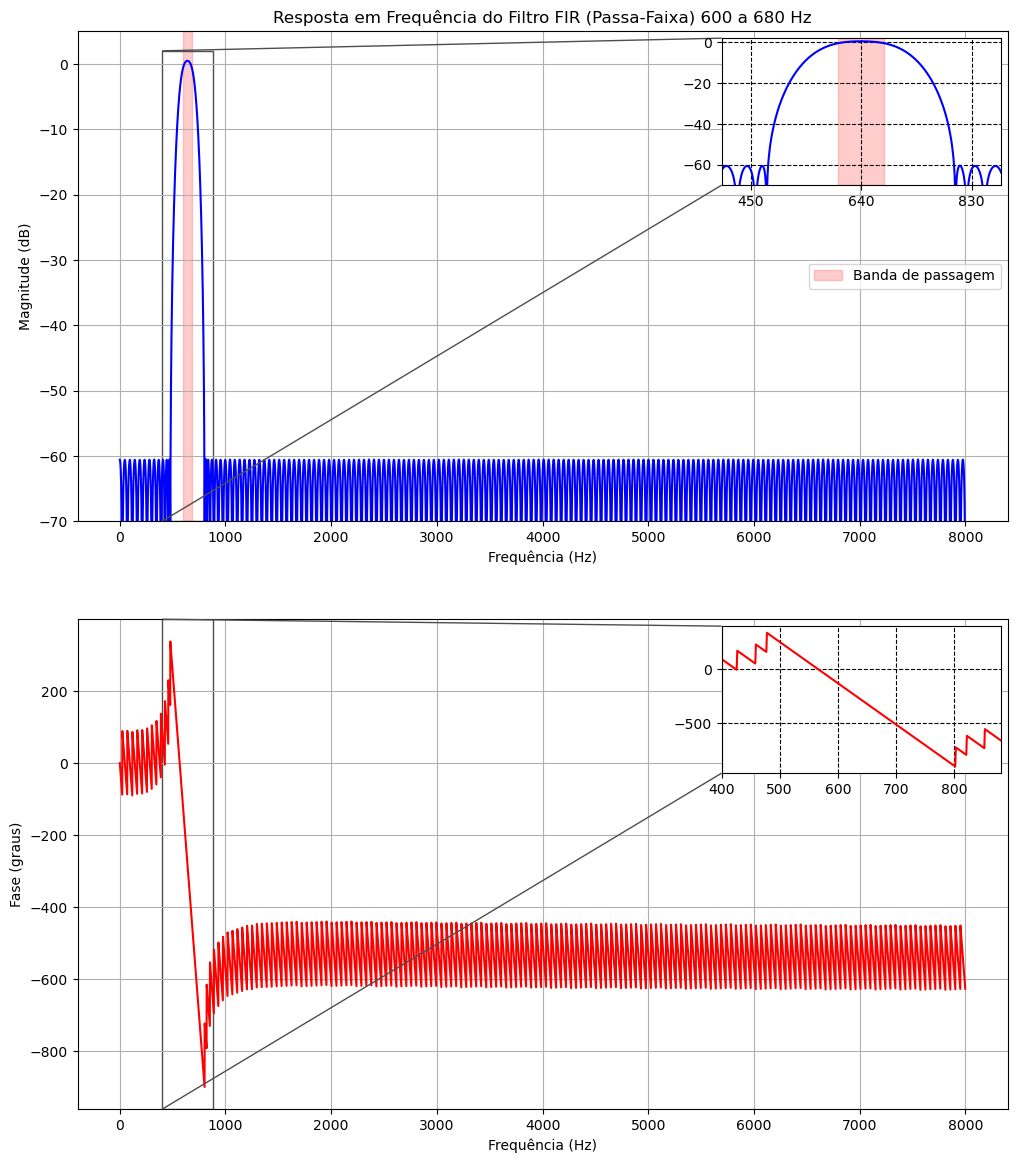

In [107]:
# Frequências normalizadas (0 a 1, onde 1 corresponde a fs/2)
nyq = sample_rate / 2

band = [600, 680]
trans_width = 120 # Quanto maior a faixa de transição melhor o resultado de atenuação na banda de rejeição 
edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width, 0.5*sample_rate]

desired_gain = [0, 1, 0]
weights = [60, 1, 60]
num_taps = 340 # Ampliando a faixa de transição, pode-se obter um filtro adequado e com menor pontos

taps  = remez(num_taps, edges, desired_gain, weight=weights, fs=sample_rate)
w, h = freqz(taps, worN=8000, fs=sample_rate)

Response_freq_FIR(frequencias[0], w, h, edges)

In [108]:
# Convolução no tempo entre os dados de áudio e filtro
cos_filtrado = np.convolve(data, taps)

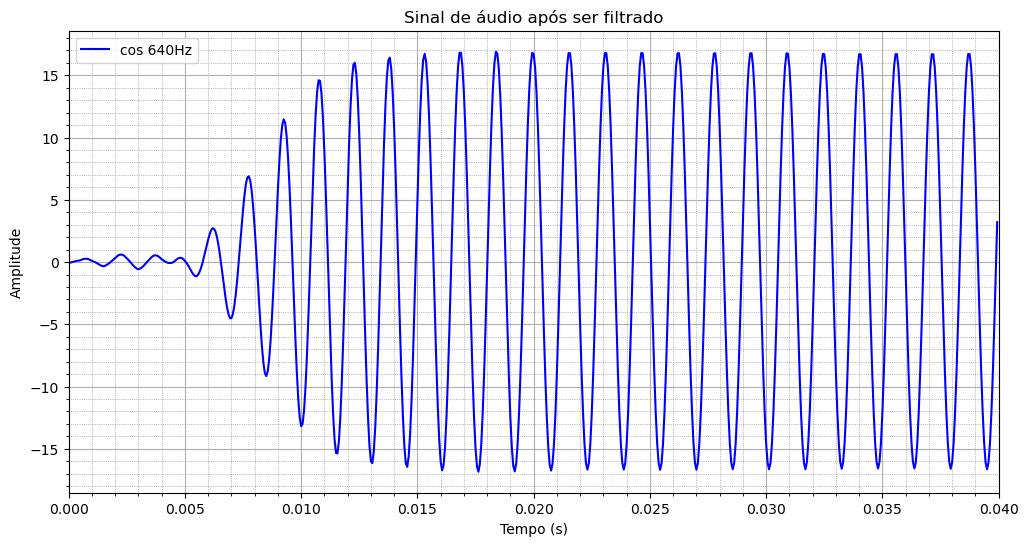

In [109]:
visual_time = 0.04 # Tempo de visualização, pois há muitas amostras para plotar

convolve_filter(frequencias[0], cos_filtrado, visual_time, sample_rate)

In [110]:
# Tempo de atraso por conta da quantidade de taps do filtro
print(f'Tempo de atraso provocado pelo filtro: {num_taps/sample_rate}s')

Tempo de atraso provocado pelo filtro: 0.02125s


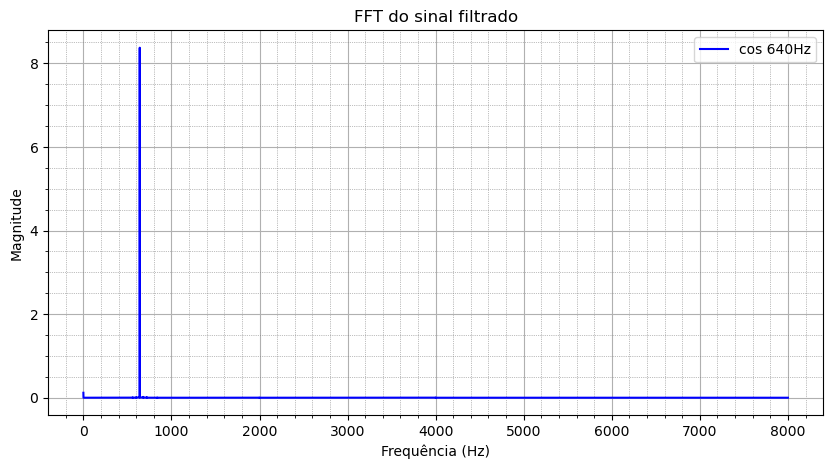

In [111]:
# FFT do Sinal Filtrado
FFT_sinal_filtrado(frequencias[0], cos_filtrado, sample_rate)

## Filtro para atenuar as componentes de 640, 2000 e 4000 Hz
Parâmetros do filtro:
1. Filtro passa faixa;
2. Ripple da banda de passagem 1dB;
3. Faixa de passagem 800 a 880 Hz;
4. Atenuação na banda de rejeição 60 dB

/tmp/ipykernel_4847/1239081472.py:15: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs[0], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[0].transAxes)
/tmp/ipykernel_4847/1239081472.py:31: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs[1], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[1].transAxes)


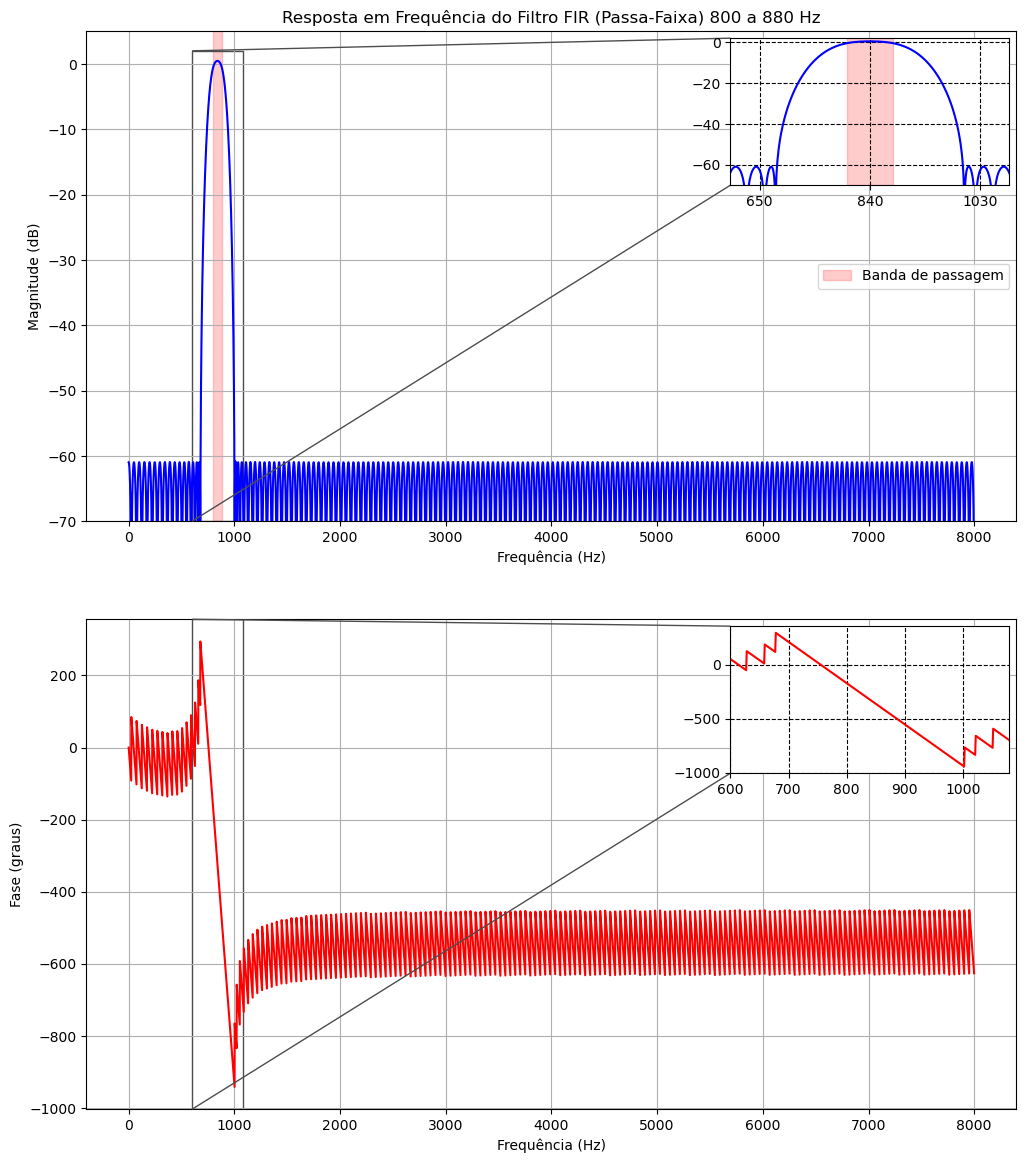

In [112]:
# Frequências normalizadas (0 a 1, onde 1 corresponde a fs/2)
nyq = sample_rate / 2

band = [800, 880]
trans_width = 120 # Quanto maior a faixa de transição melhor o resultado de atenuação na banda de rejeição 
edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width, 0.5*sample_rate]

desired_gain = [0, 1, 0]
weights = [60, 1, 60]
num_taps = 340 # Ampliando a faixa de transição, pode-se obter um filtro adequado e com menor pontos

taps  = remez(num_taps, edges, desired_gain, weight=weights, fs=sample_rate)
w, h = freqz(taps, worN=8000, fs=sample_rate)

Response_freq_FIR(frequencias[1], w, h, edges)

In [113]:
# Convolução no tempo entre os dados de áudio e filtro
cos_filtrado = np.convolve(data, taps)

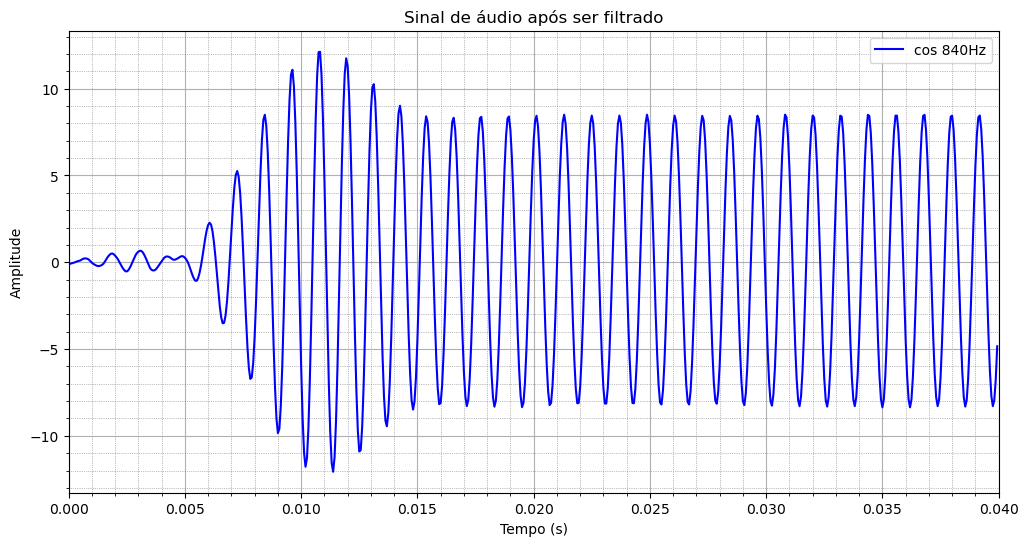

In [114]:
visual_time = 0.04 # Tempo de visualização, pois há muitas amostras para plotar

convolve_filter(frequencias[1], cos_filtrado, visual_time, sample_rate)

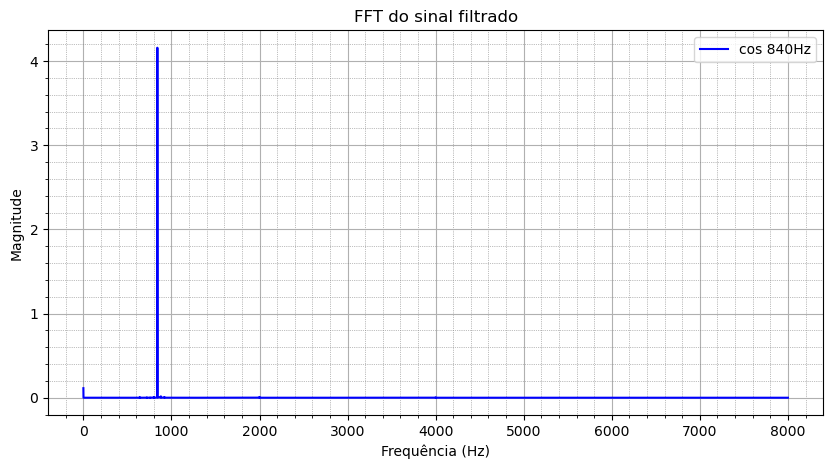

In [115]:
# FFT do Sinal Filtrado
FFT_sinal_filtrado(frequencias[1], cos_filtrado, sample_rate)

In [116]:
# Tempo de atraso por conta da quantidade de taps do filtro
print(f'Tempo de atraso provocado pelo filtro: {num_taps/sample_rate}s')

Tempo de atraso provocado pelo filtro: 0.02125s


## Filtro para atenuar as componentes de 640, 840 e 4000 Hz
Parâmetros do filtro:
1. Filtro passa faixa;
2. Ripple da banda de passagem 1dB;
3. Faixa de passagem 1500 a 2500 Hz;
4. Atenuação na banda de rejeição 60 dB

/tmp/ipykernel_4847/1239081472.py:15: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs[0], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[0].transAxes)
/tmp/ipykernel_4847/1239081472.py:31: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs[1], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[1].transAxes)


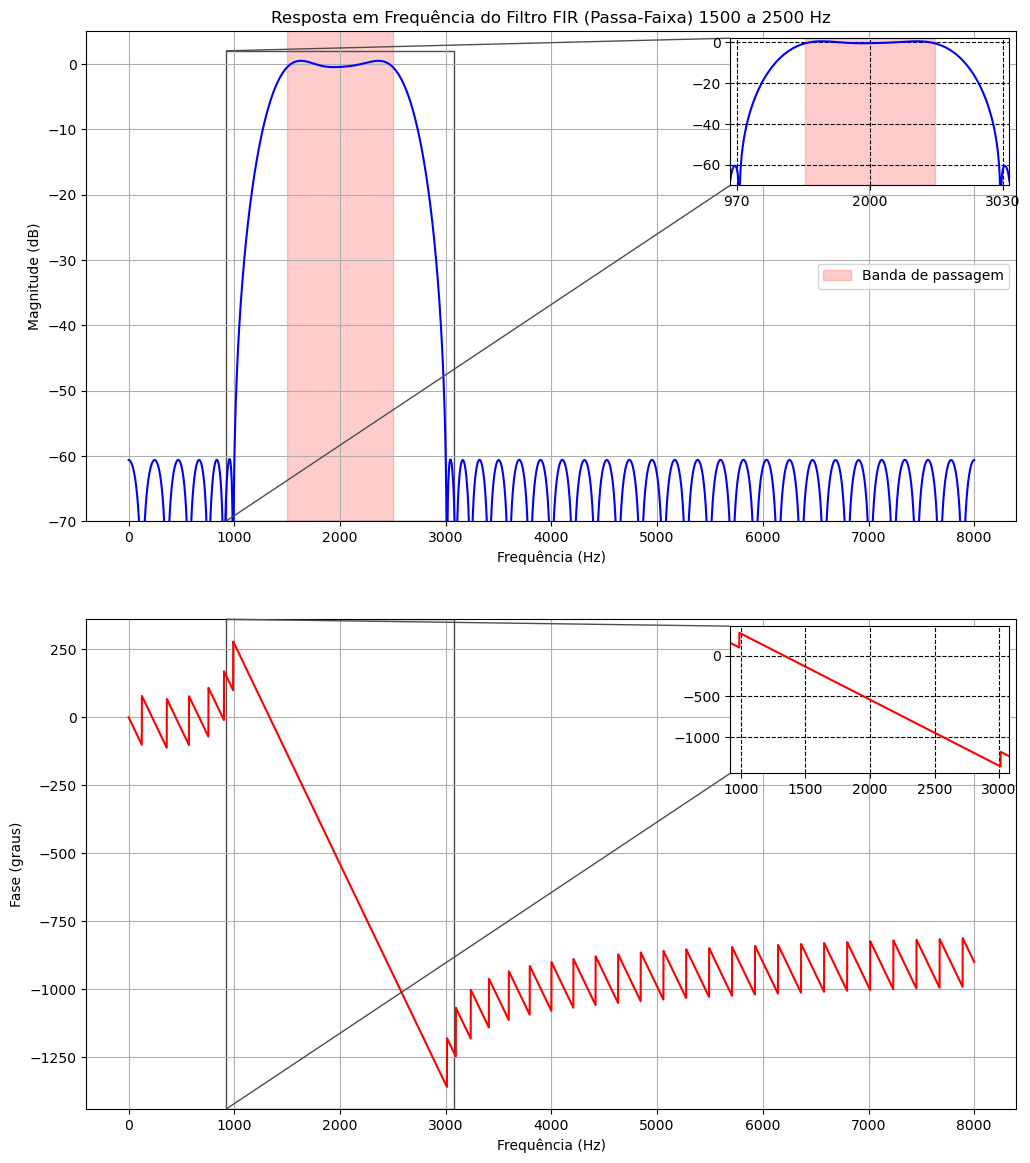

In [117]:
# Frequências normalizadas (0 a 1, onde 1 corresponde a fs/2)
nyq = sample_rate / 2

band = [1500, 2500]
trans_width = 500 # Quanto maior a faixa de transição melhor o resultado de atenuação na banda de rejeição 
edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width, 0.5*sample_rate]

desired_gain = [0, 1, 0]
weights = [60, 1, 60]
num_taps = 73 # Ampliando a faixa de transição, pode-se obter um filtro adequado e com menor pontos

taps  = remez(num_taps, edges, desired_gain, weight=weights, fs=sample_rate)
w, h = freqz(taps, worN=8000, fs=sample_rate)

Response_freq_FIR(frequencias[2], w, h, edges)

In [118]:
# Convolução no tempo entre os dados de áudio e filtro
cos_filtrado = np.convolve(data, taps)

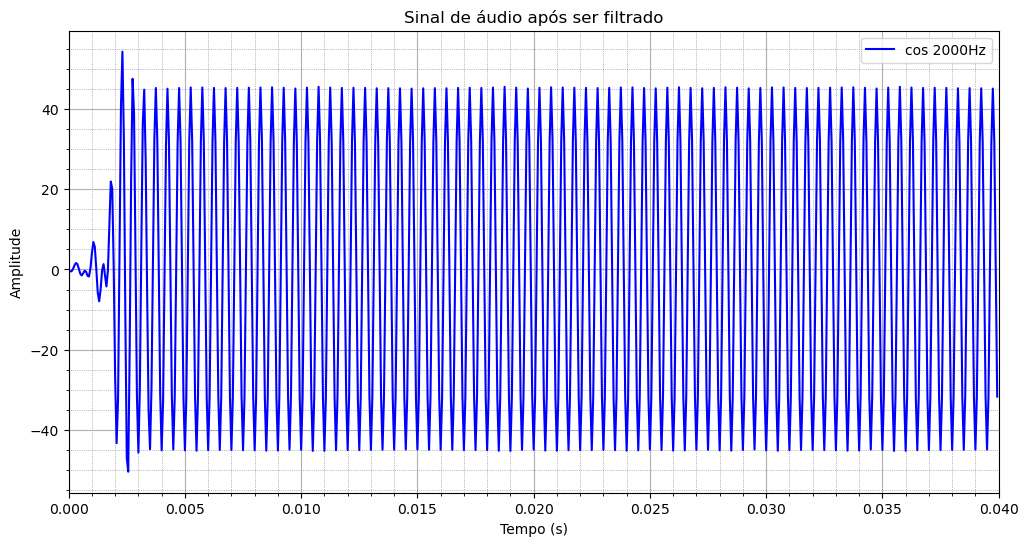

In [119]:
visual_time = 0.04 # Tempo de visualização, pois há muitas amostras para plotar

convolve_filter(frequencias[2], cos_filtrado, visual_time, sample_rate)

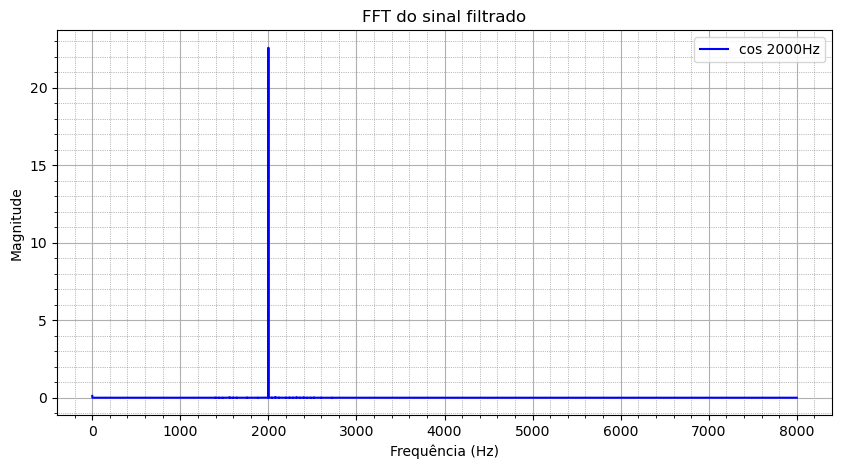

In [120]:
# FFT do Sinal Filtrado
FFT_sinal_filtrado(frequencias[2], cos_filtrado, sample_rate)

In [121]:
# Tempo de atraso por conta da quantidade de taps do filtro
print(f'Tempo de atraso provocado pelo filtro: {num_taps/sample_rate}s')

Tempo de atraso provocado pelo filtro: 0.0045625s


## Filtro para atenuar as componentes de 640, 840 e 2000 Hz
Parâmetros do filtro:
1. Filtro passa faixa;
2. Ripple da banda de passagem 1dB;
3. Faixa de passagem 3500 a 4500 Hz;
4. Atenuação na banda de rejeição 60 dB

/tmp/ipykernel_4847/1239081472.py:15: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs[0], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[0].transAxes)
/tmp/ipykernel_4847/1239081472.py:31: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs[1], width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs[1].transAxes)


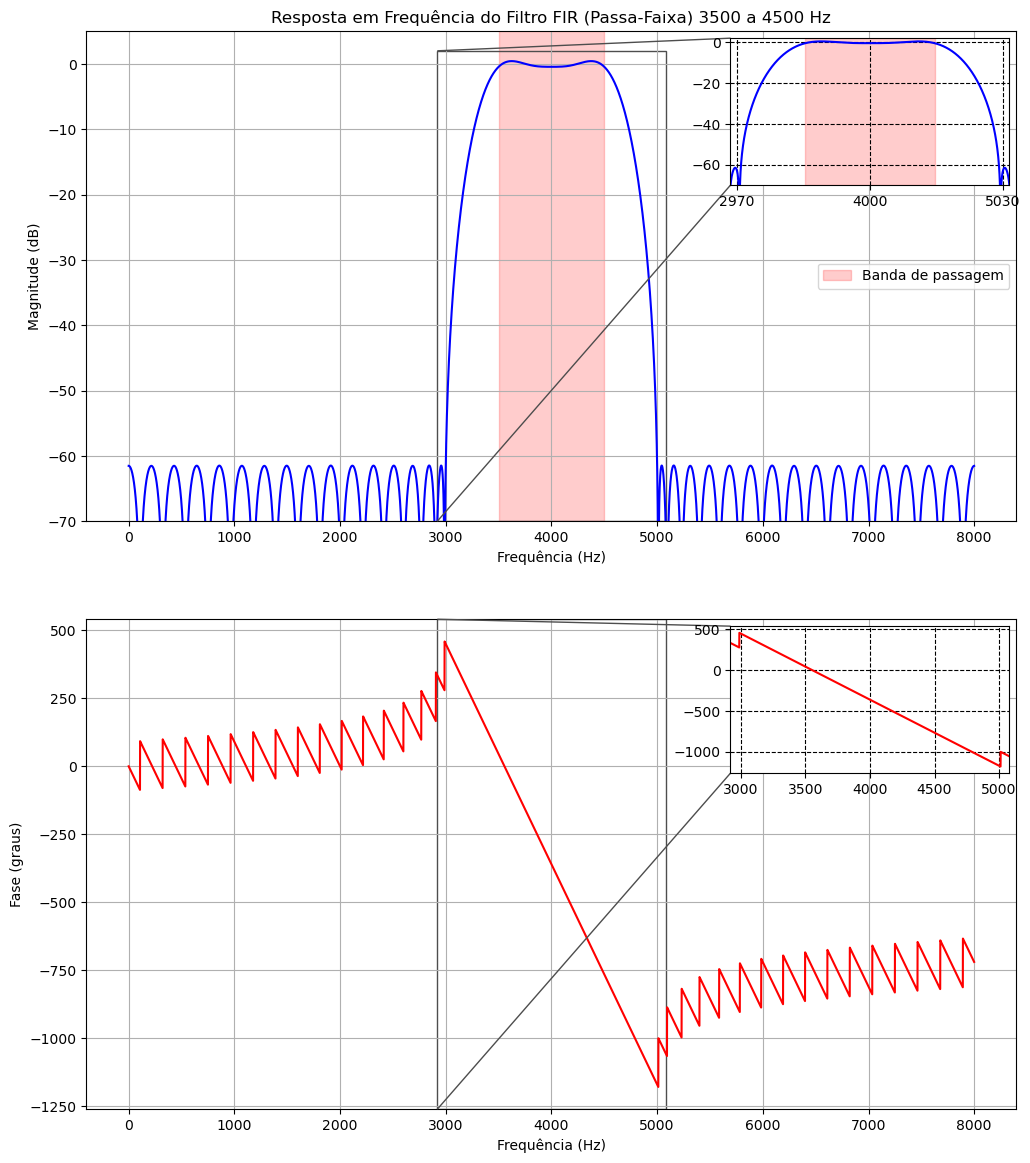

In [122]:
# Frequências normalizadas (0 a 1, onde 1 corresponde a fs/2)
nyq = sample_rate / 2

band = [3500, 4500]
trans_width = 500 # Quanto maior a faixa de transição melhor o resultado de atenuação na banda de rejeição 
edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width, 0.5*sample_rate]

desired_gain = [0, 1, 0]
weights = [60, 1, 60]
num_taps = 73 # Ampliando a faixa de transição, pode-se obter um filtro adequado e com menor pontos

taps  = remez(num_taps, edges, desired_gain, weight=weights, fs=sample_rate)
w, h = freqz(taps, worN=8000, fs=sample_rate)

Response_freq_FIR(frequencias[3], w, h, edges, zoom=30)

In [123]:
# Convolução no tempo entre os dados de áudio e filtro
cos_filtrado = np.convolve(data, taps)

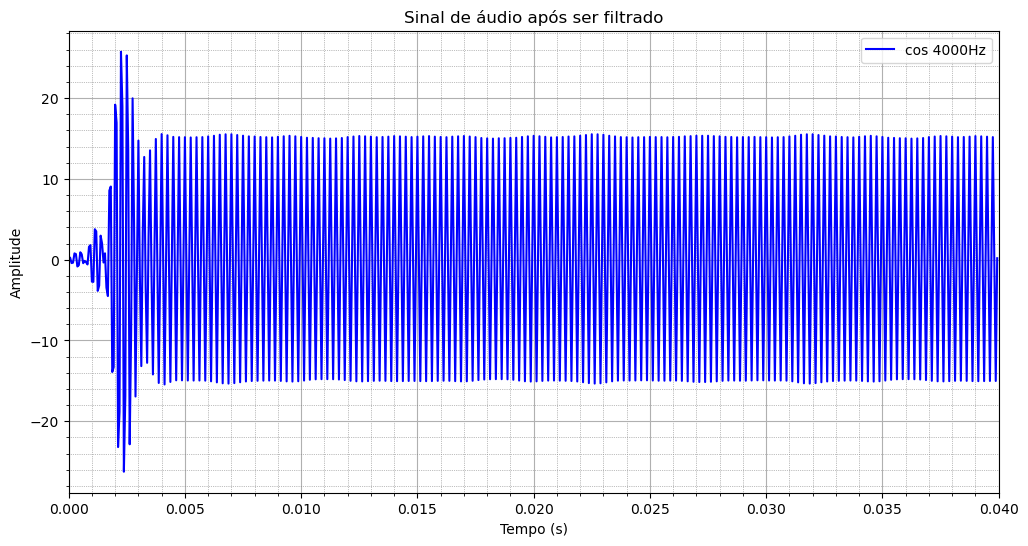

In [124]:
visual_time = 0.04 # Tempo de visualização, pois há muitas amostras para plotar

convolve_filter(frequencias[3], cos_filtrado, visual_time, sample_rate)

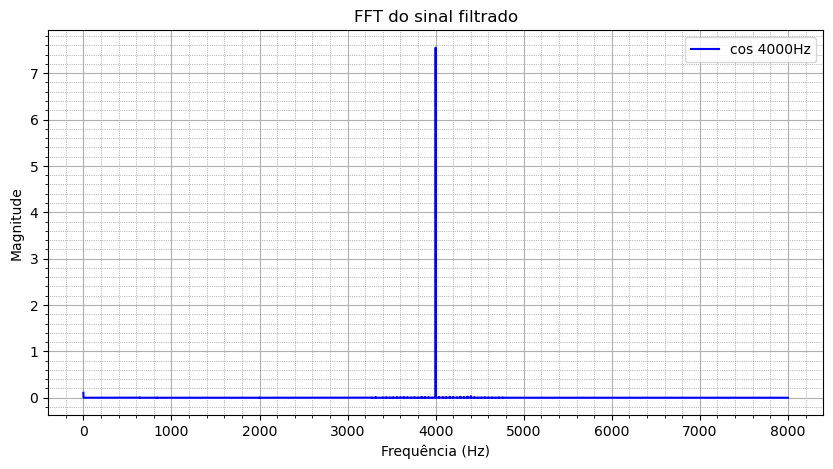

In [125]:
# FFT do Sinal Filtrado
FFT_sinal_filtrado(frequencias[3], cos_filtrado, sample_rate)

In [126]:
# Tempo de atraso por conta da quantidade de taps do filtro
print(f'Tempo de atraso provocado pelo filtro: {num_taps/sample_rate}s')

Tempo de atraso provocado pelo filtro: 0.0045625s
